<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.4 MB/s eta 0:00:00


In [2]:
! pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
!python -m spacy download en_core_web_sm

In [95]:
# Essential Libraries
import re
import spacy
import praw
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
from wordcloud import WordCloud

# NLTK Downloads (only necessary ones)
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Initialize Reddit API
reddit = praw.Reddit(
    client_id="ZRSYUiHRJOl_3XR_6ifWwQ",
    client_secret="CEeasW1hnMozmDPGh8YXBUZMN6jV9Q",
    user_agent="BitcoinScraper"
)

# List of subreddits
subreddits = ["Bitcoin", "CryptoCurrency", "CryptoMarkets"]

# Store data
posts = []

for sub in subreddits:
    subreddit = reddit.subreddit(sub)
    for post in subreddit.hot(limit=1000):  # Increase limit for more data
        posts.append([sub, post.title, post.url, post.score, post.num_comments, post.created_utc])

# Convert to DataFrame
df = pd.DataFrame(posts, columns=["Subreddit", "Title", "URL", "Upvotes", "Comments", "Timestamp"])

# Save to CSV
df.to_csv("reddit_crypto_data.csv", index=False)
print("✅ Data saved to reddit_crypto_data.csv")

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

✅ Data saved to reddit_crypto_data.csv


In [115]:
#load data
df = pd.read_csv("/content/reddit_crypto_data.csv")
df.head()

,Subreddit,Title,URL,Upvotes,Comments,Timestamp
0,Bitcoin,"Mentor Monday, February 10, 2025: Ask all your...",https://www.reddit.com/r/Bitcoin/comments/1im0...,15,19,1.739171e+09
1,Bitcoin,"Daily Discussion, February 10, 2025",https://www.reddit.com/r/Bitcoin/comments/1ilz...,26,96,1.739167e+09
2,Bitcoin,Finally hit the .1 club! Been a long time coming,https://i.redd.it/yn46u3yrafie1.jpeg,445,54,1.739242e+09
3,Bitcoin,The Perfect Smell for Guests in your House aft...,https://i.redd.it/mjhg60vzpfie1.jpeg,188,22,1.739247e+09
4,Bitcoin,Willing to meet halfway 😜,https://i.redd.it/sri21fzyxcie1.jpeg,795,24,1.739213e+09


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Subreddit  1496 non-null   object 
 1   Title      1496 non-null   object 
 2   URL        1496 non-null   object 
 3   Upvotes    1496 non-null   int64  
 4   Comments   1496 non-null   int64  
 5   Timestamp  1496 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 70.3+ KB


In [117]:
df = df.drop(columns=["URL", "Timestamp"])
print(df.head())  # Confirm removal

  Subreddit                                              Title  Upvotes  \
0   Bitcoin  Mentor Monday, February 10, 2025: Ask all your...       15   
1   Bitcoin                Daily Discussion, February 10, 2025       26   
2   Bitcoin   Finally hit the .1 club! Been a long time coming      445   
3   Bitcoin  The Perfect Smell for Guests in your House aft...      188   
4   Bitcoin                          Willing to meet halfway 😜      795   

   Comments  
0        19  
1        96  
2        54  
3        22  
4        24  


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subreddit  1496 non-null   object
 1   Title      1496 non-null   object
 2   Upvotes    1496 non-null   int64 
 3   Comments   1496 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.9+ KB


In [119]:
print(df["Subreddit"].unique())

['Bitcoin' 'CryptoCurrency' 'CryptoMarkets']


## Data Preprocessing

### 🧹 Tweet Cleaning & Preprocessing

#### ✅ Steps Taken:
1. **Removed Mentions** (`@username`)
2. **Removed URLs** (e.g., `http://example.com`)
3. **Removed Special Characters** (kept only letters and spaces)
4. **Converted to Lowercase** (standardized text format)

*Note: I used VADER for sentiment analysis, which does not require stopword removal or lemmatization, so these steps were intentionally omitted.*


In [120]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    return text.lower().strip()  # Convert to lowercase

# Apply cleaning function
df["cleaned_text"] = df["Title"].astype(str).apply(clean_text)  # Assuming "Title" holds the text

df.head()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


,Subreddit,Title,Upvotes,Comments,cleaned_text
0,Bitcoin,"Mentor Monday, February 10, 2025: Ask all your...",15,19,mentor monday february ask all your bitcoin ...
1,Bitcoin,"Daily Discussion, February 10, 2025",26,96,daily discussion february
2,Bitcoin,Finally hit the .1 club! Been a long time coming,445,54,finally hit the club been a long time coming
3,Bitcoin,The Perfect Smell for Guests in your House aft...,188,22,the perfect smell for guests in your house aft...
4,Bitcoin,Willing to meet halfway 😜,795,24,willing to meet halfway


## Sentiment Analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

VADER takes into account

negations and contractions (not good, wasn’t good) Punctuation (good!!!), CAPS, emotes :), emojis Intensificators (very, kind of), acronyms ‘lol’ Scores between -1.0 (negative) and 1.0 (positive)

### Instantiate the Analyzer

In [121]:
# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Analyze the Sentiment

In [122]:
# Function to get full polarity scores
def get_polarity(text):
    return sia.polarity_scores(text)  # Returns a dictionary with 'neg', 'neu', 'pos', 'compound'

# Apply sentiment analysis to the "Title" column
df["polarity"] = df["Title"].astype(str).apply(get_polarity)

# Expand the polarity dictionary into separate columns
polarity_df = df["polarity"].apply(pd.Series)
df = pd.concat([df, polarity_df], axis=1)

# Classify Sentiment based on compound score
df["Sentiment"] = df["compound"].apply(
    lambda x: "Positive" if x > 0.05 else "Negative" if x < -0.05 else "Neutral"
)

# View results with full polarity scores
df[["Title", "neg", "neu", "pos", "compound", "Sentiment"]].head()

,Title,neg,neu,pos,compound,Sentiment
0,"Mentor Monday, February 10, 2025: Ask all your...",0.0,1.000,0.000,0.0000,Neutral
1,"Daily Discussion, February 10, 2025",0.0,1.000,0.000,0.0000,Neutral
2,Finally hit the .1 club! Been a long time coming,0.0,1.000,0.000,0.0000,Neutral
3,The Perfect Smell for Guests in your House aft...,0.0,0.821,0.179,0.5719,Positive
4,Willing to meet halfway 😜,0.0,1.000,0.000,0.0000,Neutral


### Visualizing Sentiment Distribution

<ipython-input-123-cc506875be0d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Sentiment"], palette="coolwarm")


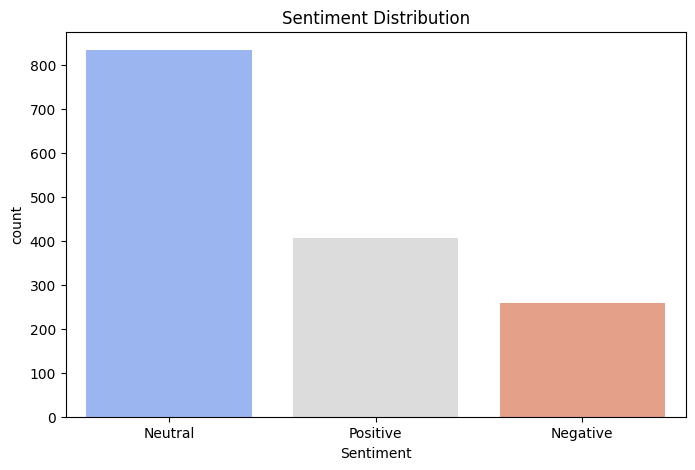

In [123]:
plt.figure(figsize=(8,5))
sns.countplot(x=df["Sentiment"], palette="coolwarm")
plt.title("Sentiment Distribution")
plt.show()

In [69]:
sentiment_by_subreddit = df.groupby("Subreddit")["Sentiment"].value_counts().unstack()
print(sentiment_by_subreddit)

Sentiment       Negative  Neutral  Positive
Subreddit                                  
Bitcoin              108      433       212
CryptoCurrency        49      102        63
CryptoMarkets        101      298       130


### Generate Word Clouds

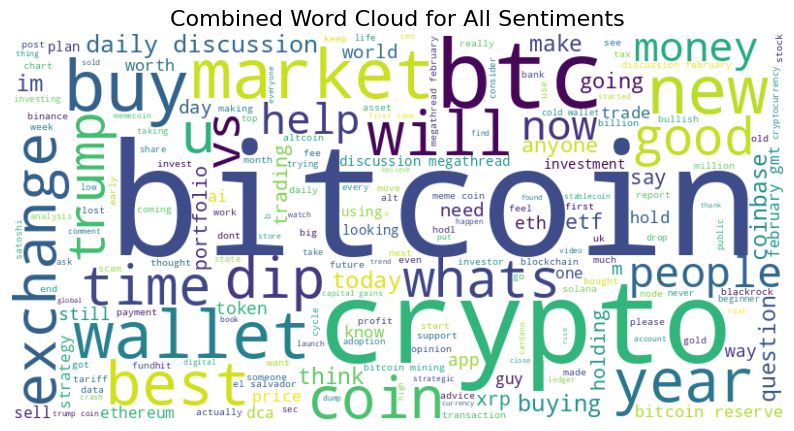

In [70]:
# Combine all cleaned text into one string
combined_text = ' '.join(df['cleaned_text'])

# Generate a single word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Plot the combined word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Combined Word Cloud for All Sentiments', fontsize=16)
plt.show()

### Compare VADER sentiment scores with the actual text content.

In [23]:
# Function to get VADER sentiment score
def get_vader_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply VADER sentiment analysis
df["VADER_Sentiment"] = df["cleaned_text"].astype(str).apply(get_vader_sentiment)

# Compare actual sentiment vs. VADER's predicted sentiment
comparison_df = df[["cleaned_text", "Sentiment", "VADER_Sentiment"]].sample(10)  # Select random 10 samples for comparison

# Display comparison
print(comparison_df)

                                           cleaned_text Sentiment  \
244                    jeff booth says use your bitcoin   Neutral   
1385  hey crypto lovers and experts meme coins have ...  Positive   
934   will blockchains transparency finally end corr...  Positive   
1249  how is xrp a good coin to make profits if the ...  Positive   
972        holding xrp hbar ada kas for the next  years   Neutral   
1125                              looking for an advice   Neutral   
668                  lets talk about exchange for spain   Neutral   
726               this man was eerily ahead of his time   Neutral   
118                                     looking forward   Neutral   
1487                             does xcn have a future   Neutral   

     VADER_Sentiment  
244          Neutral  
1385        Positive  
934         Positive  
1249        Positive  
972          Neutral  
1125         Neutral  
668          Neutral  
726          Neutral  
118          Neutral  
1487      

## ML Pipeline:

### Feature Extraction:
**Text Vectorization**

Text data needs to be transformed into numerical format since machine learning models cannot directly work with text.

I will choose TF-IDF (Term Frequency-Inverse Document Frequency) because it reflects how important a word is within a document and across the entire dataset. This is particularly useful for capturing the essence of a text review without giving too much importance to common words (like "the", "is", etc.).

TF-IDF Explanation:

TF (Term Frequency): Measures how frequently a word appears in a document.
IDF (Inverse Document Frequency): Measures how common or rare a word is across all documents. Rare words are given higher weightage.

In [71]:
# Initialize TfidfVectorizer: Limit to top 1000 words
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df["cleaned_text"])

In [72]:
#Convert to DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

      about  above  accelerating  accept  access  account  actually  ada  \
0  0.000000    0.0           0.0     0.0     0.0      0.0       0.0  0.0   
1  0.000000    0.0           0.0     0.0     0.0      0.0       0.0  0.0   
2  0.000000    0.0           0.0     0.0     0.0      0.0       0.0  0.0   
3  0.257476    0.0           0.0     0.0     0.0      0.0       0.0  0.0   
4  0.000000    0.0           0.0     0.0     0.0      0.0       0.0  0.0   

   address  adoption  ...  wrong  xlm  xrp  yall  year    years  yesterday  \
0      0.0       0.0  ...    0.0  0.0  0.0   0.0   0.0  0.00000        0.0   
1      0.0       0.0  ...    0.0  0.0  0.0   0.0   0.0  0.00000        0.0   
2      0.0       0.0  ...    0.0  0.0  0.0   0.0   0.0  0.00000        0.0   
3      0.0       0.0  ...    0.0  0.0  0.0   0.0   0.0  0.29906        0.0   
4      0.0       0.0  ...    0.0  0.0  0.0   0.0   0.0  0.00000        0.0   

        you      your  youre  
0  0.000000  0.283144    0.0  
1  0.000000 

In [73]:
# Encode sentiment labels into numeric values
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df["Sentiment_Num"] = df["Sentiment"].map(label_map)

In [74]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df["Sentiment_Num"], test_size=0.2, random_state=42
)

In [75]:
# Verify the shapes of the training and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1196, 1000)
Test set shape: (300, 1000)


### Logistic Regression

In [76]:
# Initialize and train the Logistic Regression model with balanced class weights
lr_model = LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear')
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')

### Handling Class Imbalance

To deal with class imbalance, I adjusted the Logistic Regression model by setting the `class_weight` parameter to `'balanced'`. This approach automatically adjusts the weights inversely proportional to the class frequencies, ensuring that the model gives more emphasis to the minority classes.

In [77]:
# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

In [78]:
# Evaluate Logistic Regression performance
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.6666666666666666
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.58      0.34      0.43        53
           1       0.68      0.88      0.77       169
           2       0.65      0.44      0.52        78

    accuracy                           0.67       300
   macro avg       0.64      0.55      0.57       300
weighted avg       0.66      0.67      0.64       300



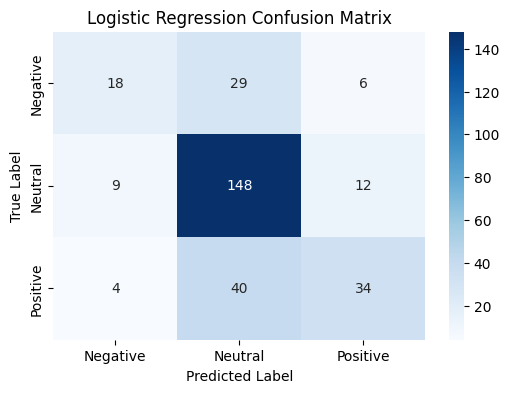

In [79]:
# Visualize the confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

### Random Forest Pipeline

In [80]:
# Initialize and train the Random Forest model with balanced class weights
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [81]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

In [82]:
# Evaluate Random Forest performance
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.6766666666666666
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.23      0.34        53
           1       0.67      0.95      0.78       169
           2       0.74      0.40      0.52        78

    accuracy                           0.68       300
   macro avg       0.69      0.52      0.55       300
weighted avg       0.69      0.68      0.63       300



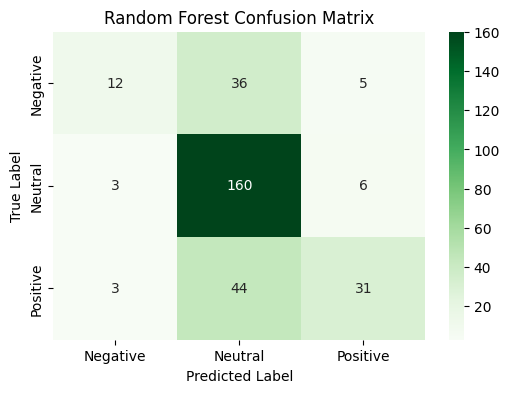

In [83]:
# Visualize the confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

### Tuning the Random Forest Model

RandomizedSearchCV

In [84]:
# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [85]:
# Initialize the Random Forest model with balanced class weights
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

In [86]:
# Set up RandomizedSearchCV for tuning (using 30 random combinations and 5-fold CV)
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=30,           # Number of parameter settings sampled
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',  # Scoring metric can be changed if needed
    n_jobs=-1,           # Use all available cores
    random_state=42,
    verbose=1
)

In [87]:
# Fit the RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Print the best parameters found and extract the best model
print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}


In [88]:
# Evaluate the tuned model on the test set
y_pred_best = best_rf.predict(X_test)
print("Test Accuracy with Tuned Random Forest:", accuracy_score(y_test, y_pred_best))
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

Test Accuracy with Tuned Random Forest: 0.6566666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.30      0.40        53
           1       0.68      0.86      0.76       169
           2       0.62      0.46      0.53        78

    accuracy                           0.66       300
   macro avg       0.62      0.54      0.56       300
weighted avg       0.64      0.66      0.63       300



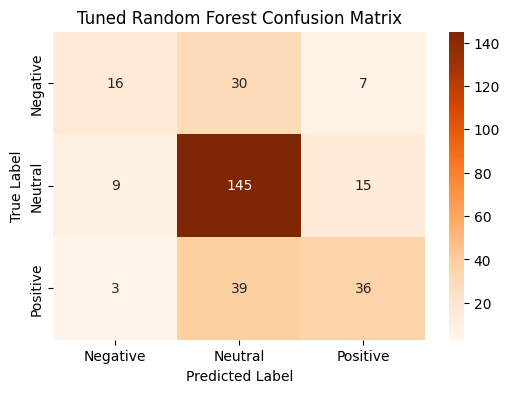

In [89]:
# Generate and visualize the confusion matrix for the tuned model
cm_tuned = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tuned, annot=True, fmt="d", cmap="Oranges",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tuned Random Forest Confusion Matrix')
plt.show()